# PPI power analysis



In [160]:
%reload_ext autoreload
%autoreload 2

In [182]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.power_ppi import ppi_power, ppi_mean_power, ppi_ols_power, ppi_poisson_power
from ppi_py.ppi import ppi_mean_ci, ppi_ols_ci, ppi_poisson_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.stats import norm
from utils import *
import warnings
warnings.simplefilter('always', UserWarning)

## Power analysis with known $\tilde{\rho}$

The function `ppi_power` computes an optimal pair of sample sizes given the PPI-correlation $\tilde{\rho}$ and the costs of $Y$, $f(X)$ and $X$. The output is a Pandas array. 

If `budget` is provided, then `ppi_power` will compute the *most powerful pair*. The most powerful pair is the pair of sample sizes $(n, N)$ that achieves the lowest standard error within the given budget.

In [183]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

budget = 865

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget = budget)
optimal_pair

{'n': 604,
 'N': 12406,
 'cost': 864.2,
 'se': 0.015191891148339126,
 'rho': 0.95,
 'effective_n': 4332}

The following visualization shows that the computed pair is indeed optimal.

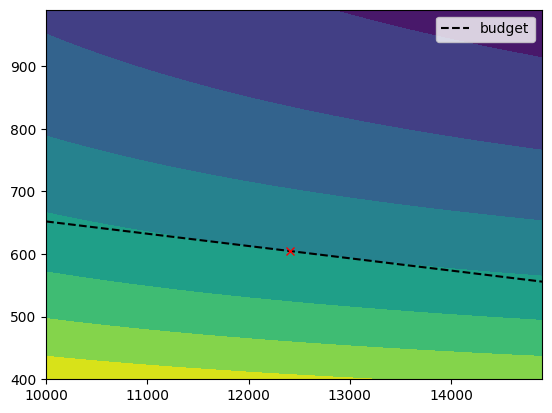

In [184]:
n = np.arange(400, 1000, 10)
N = np.arange(10000, 15000, 100)
ns, Ns = np.meshgrid(n, N)
ppi_se = np.sqrt(sigma_sq/ns * (1 - Ns/(Ns+ns)*rho**2))
plt.contourf(Ns, ns, ppi_se)
n_cost = (budget - N*(cost_X + cost_Yhat))/(cost_X + cost_Y + cost_Yhat)
plt.plot(N, n_cost, "k--", label = "budget")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']

plt.plot(N_opt, n_opt, 'rx')
plt.legend()
plt.show()

If there is a limit on the number of $X$ samples available. Then the input `n_max` should be provided. When `n_max` is provided, the output will satisfy the additional constraint `n + N <= n_max`.

{'n': 665, 'N': 9335, 'cost': 865.0000000000001, 'se': 0.01539046917262055, 'rho': 0.95, 'effective_n': 4221}


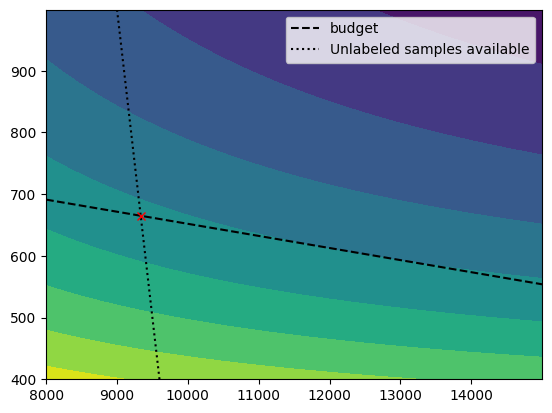

In [185]:
n_max = 10000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget = budget, n_max = n_max)
print(optimal_pair)

n = np.arange(400, 1000)
N = np.arange(8000, 15000)
ns, Ns = np.meshgrid(n, N)
ppi_se = np.sqrt(sigma_sq/ns * (1 - Ns/(Ns+ns)*rho**2))
plt.contourf(Ns, ns, ppi_se)
n_cost = (budget - N*(cost_X + cost_Yhat))/(cost_X + cost_Y + cost_Yhat)
N_max_constraint = n_max - n


plt.plot(N, n_cost, "k--", label = "budget")
plt.plot(N_max_constraint, n, "k:", label = "Unlabeled samples available")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']

plt.plot(N_opt, n_opt, 'rx')
plt.legend()
plt.show()


## Power analysis for cheapest pair

If the input `se` is provided instead of `budget`, then `ppi_power` will compute the *cheapest pair*. This is the pair $(n,N)$ that minimizes the cost while achieving a PPI standard error of `se`. 

In [186]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

se = 0.00975

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se)
optimal_pair

{'n': 1466,
 'N': 30091,
 'cost': 2097.14,
 'se': 0.009752258528781628,
 'rho': 0.95,
 'effective_n': 10514}

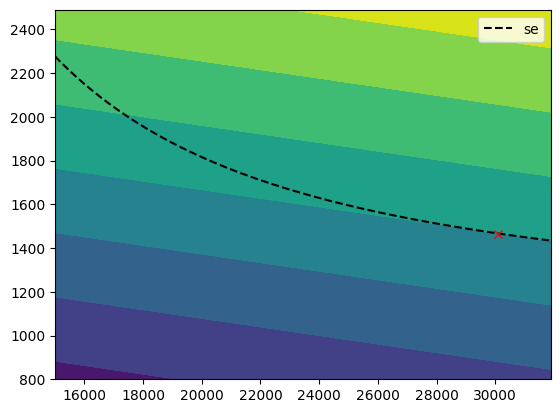

In [187]:
n = np.arange(800, 2500, 10)
N = np.arange(15000, 32000, 100) 
ns, Ns = np.meshgrid(n, N)
costs = ns * (cost_X + cost_Yhat + cost_Y) + Ns * (cost_X + cost_Yhat)
plt.contourf(Ns, ns, costs)

n_se = (-se**2 * N + sigma_sq + (se**4 *N **2 + 2*se**2 * N * sigma_sq - 4 * se**2 * N * rho**2 * sigma_sq + sigma_sq**2)**0.5) /2/se**2
plt.plot(N, n_se, "k--", label = "se")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']
plt.plot(N_opt, n_opt, 'rx')
plt.legend()
plt.show()


As with the most powerful pair, the cheapest pair has an optional input `n_max`. When `n_max` is provided, the output will satisfy the constraint `n+N <= n_max`.

{'n': 1653, 'N': 23347, 'cost': 2153.0, 'se': 0.009751085378649191, 'rho': 0.95, 'effective_n': 10517}


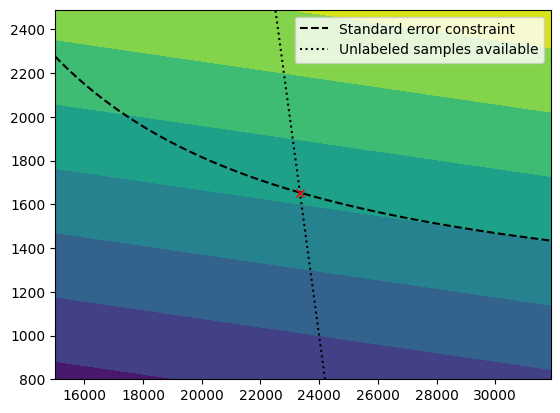

In [188]:
n_max = 25000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se, n_max = n_max)
print(optimal_pair)

plt.contourf(Ns, ns, costs)
plt.plot(N, n_se, "k--", label = "Standard error constraint")

N_max_constraint = n_max - n
plt.plot(N_max_constraint, n, "k:", label = "Unlabeled samples available")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']
plt.plot(N_opt, n_opt, 'rx')
plt.legend()
plt.show()

It is possible that no pair of sample sizes can achieve the desired `se` and satisfy `n+N <= n_max`. In this case, `ppi_power` will give a warning and return `n = n_max` and `N = 0`.

In [197]:
n_max = 10000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se, n_max = n_max)
print(optimal_pair)

{'n': 10000, 'N': 0, 'cost': 10100.0, 'se': 0.01, 'rho': 0.95, 'effective_n': 10000}


c:\Users\micha\Documents\GitHub\ppi_py\ppi_py\power_ppi.py:265: UserWarning: The desired standard error is too small for the given number of unlabeled samples. Returning n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.
  raise UserWarning("The desired standard error is too small for the given number of unlabeled samples. Return n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.")


## Power analysis for the mean

In general $\tilde{\rho}$ and $\sigma^2$ have to be estimated from data. The functions `ppi_<estimator>_power` estimate these parameters for different PPI estimators and then compute the optimal pair. 

The following example performs a power analysis for estimating the mean using the `ballots` dataset from *Angelopoulos et al (2023)*. A random subsample of $n=500$ labeled points and $N=500$ unlabeled points is used to estimate $\tilde{\rho}$ and $\sigma^2$. The output is again a pandas dataframe showing the most powerful pair within the given budget.

In [135]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 500
N_initial = 500

labeled_initial = np.random.choice(n, n_initial, replace = False)
unlabeled_initial = np.random.choice(N, N_initial, replace = False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]
cost_Y = 1
cost_Yhat = 0.01

most_powerful_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, budget = 1000)
most_powerful_pair

{'n': 661,
 'N': 33227,
 'cost': 999.88,
 'se': np.float64(0.00449087123416354),
 'rho': np.float64(0.9814967937419823),
 'effective_n': 11919}

The functions `ppi_<estimator>_power` can also be used to compute the cheapest pair achieving a desired standard error.

In [136]:
se = 0.01
cheapest_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se =  se)
cheapest_pair

{'n': 133,
 'N': 6700,
 'cost': 201.32999999999998,
 'se': np.float64(0.010008074940038877),
 'rho': np.float64(0.9814967937419823),
 'effective_n': 2400}

The functions `ppi_<estimator>_power` also have an optional `n_max` argument.

In [137]:
n_max = 2500
cheapest_pair_2 = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se =  se, n_max = n_max)
cheapest_pair_2

{'n': 1196,
 'N': 1304,
 'cost': 1221.0,
 'se': np.float64(0.010000115850441046),
 'rho': np.float64(0.9814967937419823),
 'effective_n': 2403}

The data driven power analysis is subject to estimation error in $\tilde{\rho}$ and $\sigma^2$. To illustrate this, we take the sample sizes from `most_powerful_pair` and generate multiple samples of the given size. We run PPI on each sample and compute the standard error. The histogram compares the estimated standard error to the observed standard errors.

In [138]:
n_opt = most_powerful_pair['n']
N_opt = most_powerful_pair['N']

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_opt, replace = False)
    unlabeled_sample = np.random.choice(N, N_opt, replace = False)

    Y_opt = Y[labeled_sample]
    Yhat_opt = Yhat[labeled_sample]
    Yhat_unlabeled_opt = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_opt, Yhat_opt, Yhat_unlabeled_opt, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2

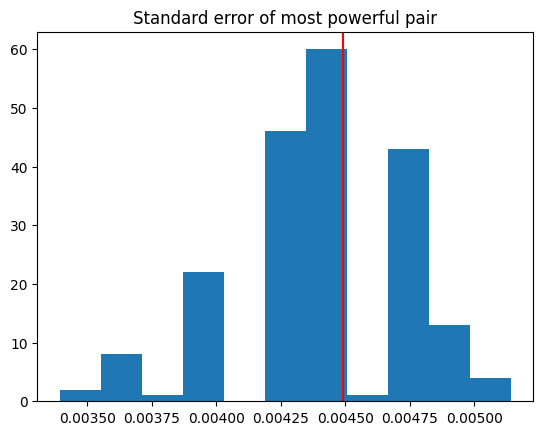

In [139]:
plt.hist(ses, bins = 11, label="Emprical standard errors")
plt.axvline(most_powerful_pair['se'], color = 'red', label = "Predicted standard error")
plt.title("Standard error of most powerful pair")
plt.legend()
plt.show()

One way to quantify the estimation uncertainty in estimating $\tilde{\rho}$ and $\sigma^2$ is to perform the bootstrap on the initial datasets and perform a power analysis on each bootstrap resample. This will give a range of plausible values of $\tilde{\rho}$ and $\sigma$. 

## Power analysis for linear regression

The function `ppi_ols_power` performs a data-driven power analysis for linear regression. This is illustrated using the `census_income` dataset from *Angelopolous et al (2023)*.


In [150]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0
se = 50

cheapest_pair = ppi_ols_power(X_initial, 
                                   Y_initial, 
                                   Yhat_initial,
                                   X_unlabeled_initial,
                                   Yhat_unlabeled_initial, 
                                   cost_Y, 
                                   cost_Yhat, 
                                   cost_X,
                                   coord,
                                   se = se)
cheapest_pair

{'n': 2479,
 'N': 9933,
 'cost': 2727.24,
 'se': np.float64(50.00118755182774),
 'rho': np.float64(0.5778804521490668),
 'effective_n': 3383}

Again we can compare the estimated standard error to the observed standard error from subsampling the data.

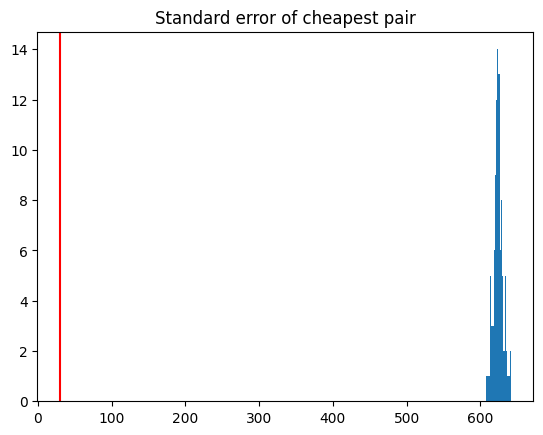

In [146]:
n_opt = cheapest_pair['n']
N_opt = cheapest_pair['N']

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_opt + N_opt, replace = False)
    Y_opt = Y_total[sample[:n_opt]]
    Yhat_opt = Yhat_total[sample[:n_opt]]
    X_opt = X_total[sample[:n_opt]]
    Yhat_unlabeled_opt = Yhat_total[sample[n_opt:]]
    X_unlabeled_opt = X_total[sample[n_opt:]]

    CI = ppi_ols_ci(X_opt, Y_opt, Yhat_opt, X_unlabeled_opt, Yhat_unlabeled_opt, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
plt.hist(ses, bins = 20, label="Emprical standard errors")
plt.axvline(cheapest_pair['se'], color = 'red', label = "Predicted standard error")
plt.title("Standard error of cheapest pair")
plt.show()    

## Census education (Poisson regression)

Next we perform a power analysiss for a Poisson regression problem with `ppi_poisson_power`.


In [142]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]/10000 # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0

most_powerful_pair = ppi_poisson_power(X_initial, 
                                       Y_initial, 
                                       Yhat_initial,
                                       X_unlabeled_initial,
                                       Yhat_unlabeled_initial, 
                                       cost_Y, 
                                       cost_Yhat, 
                                       cost_X,
                                       coord,
                                       budget = 5000)
most_powerful_pair

{'n': 4375,
 'N': 26858,
 'cost': 4999.66,
 'se': np.float64(51.861840267043846),
 'rho': np.float64(0.7104595269137313),
 'effective_n': 7730}

In [143]:
cheapest_pair = ppi_poisson_power(X_initial, 
                                Y_initial, 
                                Yhat_initial,
                                X_unlabeled_initial,
                                Yhat_unlabeled_initial, 
                                cost_Y, 
                                cost_Yhat, 
                                cost_X,
                                coord,
                                se = 30)
cheapest_pair

{'n': 13074,
 'N': 80260,
 'cost': 14940.68,
 'se': np.float64(30.00080974351629),
 'rho': np.float64(0.7104595269137313),
 'effective_n': 23100}

In [148]:
n_opt = most_powerful_pair['n']
N_opt = most_powerful_pair['N']

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_opt + N_opt, replace = False)
    Y_opt = Y_total[sample[:n_opt]]
    Yhat_opt = Yhat_total[sample[:n_opt]]
    X_opt = X_total[sample[:n_opt]]
    Yhat_unlabeled_opt = Yhat_total[sample[n_opt:]]
    X_unlabeled_opt = X_total[sample[n_opt:]]

    CI = ppi_poisson_ci(X_opt, Y_opt, Yhat_opt, X_unlabeled_opt, Yhat_unlabeled_opt, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
    

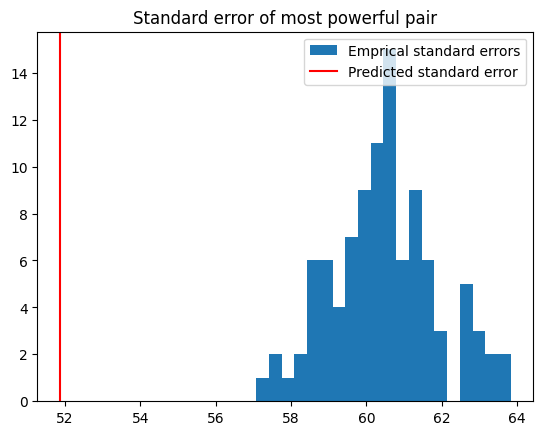

In [149]:
plt.hist(ses, bins = 20, label="Emprical standard errors")
plt.axvline(most_powerful_pair['se'], color = 'red', label = "Predicted standard error")
plt.legend()
plt.title("Standard error of most powerful pair")
plt.show()